# grid world
Here's a little gridworld implementation that works in conjunction with [openai gym](https://gym.openai.com/). The agent (☺) can move left, right, up, and down in arbitrary, user-defined mazes. A `nonterminal_reward` is emited at every time step until a terminal state is reached, at which point the agent gets a user-defined reward.

Here's how we create a maze:

In [1]:
import gym
import rickgrid
import numpy as np
import matplotlib.pyplot as plt
from rickgrid import Control

# define simple maze
np.random.seed(0)
env = gym.make('RickGrid-v0',
               walls = np.array([[0,0,1,0,0],
                                 [0,0,1,0,0],
                                 [0,0,1,0,0],
                                 [0,0,1,0,0],
                                 [0,0,0,0,0]], dtype='bool'),
               terminal_states = [[0,4,1]],     # each reward is a terminal state characterized by [row, col, value]
               start_coords = [0,0],    # where the agent starts
               nonterminal_reward=-1)   # -1 per non-terminal step

We have take actions and visualize the results as follows:

In [2]:
env.render(); # show maze
env.step(1);  # step to the right
env.render(); # show maze again


██████████████
██☺   ██   1██
██    ██    ██
██    ██    ██
██    ██    ██
██          ██
██████████████

██████████████
██  ☺ ██   1██
██    ██    ██
██    ██    ██
██    ██    ██
██          ██
██████████████


# q learning
We can learn policies using action-value based tabular approaches, each of which acts $\epsilon$-greedy with respect to $\hat{q}(s,a)$.

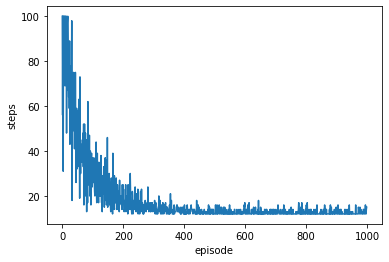

In [3]:
# set up Q Learning object
ctl_q = Control.QLearning(env)

# train, recording number of steps per episode
steps_q, rewards_q = ctl_q.train(alpha=.05, gamma=1, epsilon=.05, episodes=1000);

# plot steps per episode
ax = plt.axes(xlabel='episode', ylabel='steps')
ax.plot(steps_q);

The number of steps per episode decreases with learning. Nice. Note that episodes terminate automatically after 100 steps if a terminal state hasn't been reached.

Let's check out the policy by passing $\hat{q}(s,a)$ to the environment renderer:

In [4]:
env.reset()
env.render(Q=ctl_q.Q);


██████████████
██☺ ⇩ ██ ⇨ 1██
██⇩ ⇩ ██ ⇨⇧ ██
██ ⇨⇩ ██ ⇨⇧ ██
██⇩ ⇩ ██⇧ ⇧ ██
██ ⇨ ⇨ ⇨⇧ ⇧ ██
██████████████


This looks non-crazy! Let's see how the action-value function changes over time. Below I'm showing the max across actions (left column) and the value for each of four actions as estimated over the first 4 episodes. Structure in the value function emerges super quickly:

episode 1


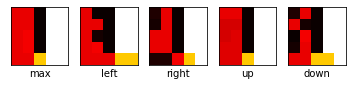

episode 2


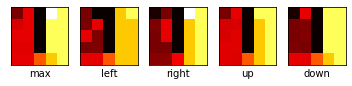

episode 3


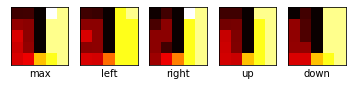

episode 4


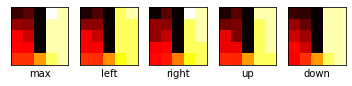

In [5]:
ctl_q.resetQ();  # reset Q to initial values

for i in range(1,5):
    steps_q, rewards_q = ctl_q.train(alpha=.05, gamma=1, epsilon=.05, episodes=1)
    print('episode {}'.format(i))
    ctl_q.plotQ();
    
    

# monte carlo

Here's a simple implementation of Monte Caro using a non-stationary estimate of the action value function: $\hat{q}(S_t,A_t) \leftarrow \hat{q}(S_t,A_t) + \alpha[G_t - \hat{q}(S_t,A_t)]$


██████████████
██☺ ⇩ ██ ⇨ 1██
██ ⇨⇩ ██⇧ ⇧ ██
██ ⇨⇩ ██ ⇨⇧ ██
██ ⇨⇩ ██ ⇨⇧ ██
██ ⇨ ⇨ ⇨⇧ ⇧ ██
██████████████


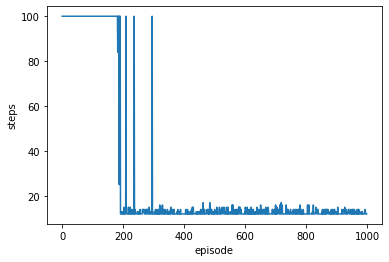

In [6]:
# set up Monte Carlo object
ctl_mc = Control.MonteCarlo(env)

# train, recording number of steps per episode
steps_mc, rewards_mc = ctl_mc.train(alpha=.05, gamma=1, epsilon=.05, episodes=1000)

# show policy
env.reset()
env.render(Q=ctl_mc.Q);

# plot steps per episode
ax = plt.axes(xlabel='episode', ylabel='steps')
ax.plot(steps_mc);

The learning curve is a little goofy. There seems to be an 'aha' moment. The agent has to 'accidentally' discover the terminal location at least once before learning can really occur. This could be a major challenge, especially if the path to the reward were longer than it is.

# explore vs. exploit maze
Default mazes are defined in `rickgrid.mazes`, and include one where an agent should learn to ignore a proximal reward for a big reward that can only be discovered via exploration.



In [7]:
from rickgrid.mazes import mazes
env = gym.make('RickGrid-v0', **mazes[0])
env.render();


████████████████████████████████████████████
██☺     ██        ██                      ██
██  ██    ██████  ██  ██████████████████  ██
██    ██          ██            ██        ██
██  ██  ████████  ██  ████████████  ████████
██            ██               1██      99██
████████████████████████████████████████████


Let's apply our Q-Learning strategy from above:

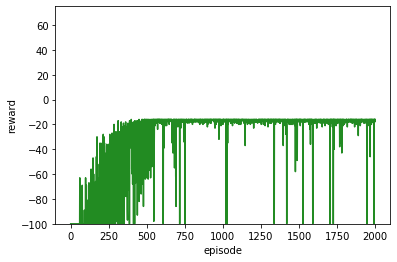

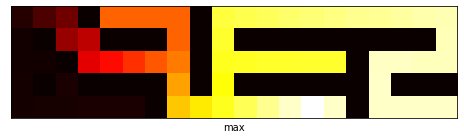

In [8]:
ctl_q = Control.QLearning(env)
steps_q, rewards_q = ctl_q.train(alpha=.05, gamma=1, epsilon=.05, episodes=2000)

# plot rewards and value function
ax = plt.axes(xlabel='episode', ylabel='reward', ylim=[-100,75])
ax.plot(rewards_q, color='forestgreen');
ctl_q.plotQ(figsize=(8,32), max_only=True)

The reward is clearly increasing, but is maxes out around -20 - must lower that what the agent would get if the 99 reward is discovered. The value function reveals why. The corridor with the 1 is drawing the agent in, leaving the more valuable corridor insufficiently explored. Let's fix this:

## fix 1: optimism in the face of uncertainty

Let's initialize the $\hat{q}$ with exremely optimistic values of 99. This will encourage the agent to explore the unexplored, and ultimately discover the big reward as a result.

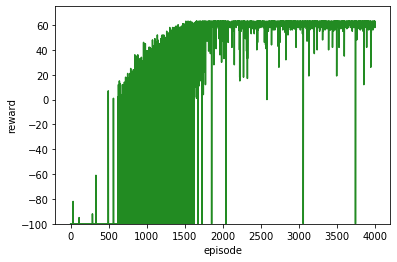

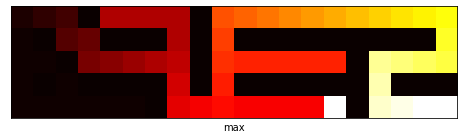

In [9]:
ctl_q = Control.QLearning(env, Q_init=99)  # initialize Q with values of 99
steps_q, rewards_q = ctl_q.train(alpha=.05, gamma=1, epsilon=.05, episodes=4000)

# plot rewards and value function
ax = plt.axes(xlabel='episode', ylabel='reward', ylim=[-100,75])
ax.plot(rewards_q, color='forestgreen');
ctl_q.plotQ(figsize=(8,32), max_only=True)

Success! Take a look at the policy below. Some of the states that are never visited under the current policy still have weird actions (like in the lower left corner). This does not affect the performance unless non-greedy actions pull the agent to these unexplored corners of the state space.

In [10]:
env.reset()
env.render(Q=ctl_q.Q);


████████████████████████████████████████████
██☺  ⇨⇩ ██ ⇦ ⇦ ⇦ ⇨██ ⇨ ⇨ ⇨ ⇨ ⇨ ⇨ ⇨ ⇨ ⇨ ⇨⇩ ██
██⇩ ██ ⇨⇩ ██████⇩ ██⇧ ██████████████████⇩ ██
██ ⇦⇩ ██ ⇨ ⇨ ⇨ ⇨⇩ ██⇧  ⇨⇩  ⇨⇩  ⇨██⇩  ⇦ ⇦ ⇦██
██ ⇨██⇧ ████████⇩ ██⇧ ████████████⇩ ████████
██ ⇨ ⇨⇩ ⇧  ⇨⇩ ██ ⇨ ⇨⇧  ⇦⇧ ⇧ ⇩  1██ ⇨ ⇨ ⇨99██
████████████████████████████████████████████


## fix 2: exploring starts

Instead of starting the agent in the top left corner every time, let's randomly position the agent at the beginning of every try. This will ensure that the state space is fully explored, and should fix the weird decisions that are made in unvisisted states in the policy above. We'll need to train it for a bit longer though.

In [14]:
env_rando = gym.make('RickGrid-v0', **mazes[0], random_start=True)
ctl_q = Control.QLearning(env_rando)
steps_q, rewards_q = ctl_q.train(alpha=.05, gamma=1, epsilon=.05, episodes=10000)

# plot the policy
env_rando.reset(start_coords=[0,0])
env_rando.render(Q=ctl_q.Q);


████████████████████████████████████████████
██☺  ⇨⇩ ██ ⇨ ⇨ ⇨⇩ ██⇩  ⇨ ⇨ ⇨ ⇨ ⇨ ⇨ ⇨ ⇨ ⇨⇩ ██
██⇧ ██ ⇨⇩ ██████⇩ ██⇩ ██████████████████⇩ ██
██⇧  ⇦██ ⇨ ⇨ ⇨ ⇨⇩ ██⇩  ⇦ ⇦ ⇦ ⇦ ⇦██⇩  ⇦ ⇦ ⇦██
██⇧ ██⇩ ████████⇩ ██⇩ ████████████⇩ ████████
██⇧  ⇦ ⇦ ⇦ ⇦ ⇦██ ⇨ ⇨ ⇨ ⇨ ⇨ ⇨ ⇨ 1██ ⇨ ⇨ ⇨99██
████████████████████████████████████████████


The policy is now perfect. Let's see how Monte Carlo with exploring starts performs:

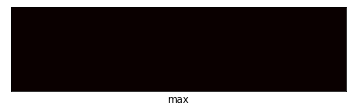

In [16]:
ctl = Control.MonteCarlo(env_rando)
steps_q, rewards_q = ctl_q.train(alpha=.05, gamma=1, epsilon=.05, episodes=10000)

# plot learning
ctl.plotQ(max_only=True)